Loading data for seasons: ['21-22', '22-23', '23-24', '24-25'] to create combined_df
Combined data shape: (120, 15)

--- Analyzing Target: Wins ---
  Features used: ['ORTG', 'DRTG', 'TS_Percent', 'TOV_Percent', 'Team_3s_Attempted', 'Weighted_Avg_Height', 'Weighted_Avg_Wingspan']

  --- Linear Regression ---
    LR R-squared: 0.899
    LR MAE: 2.613
    LR RMSE: 11.659


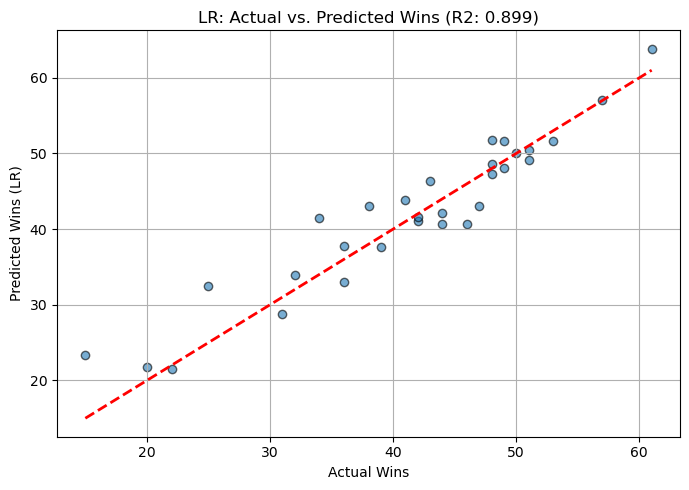

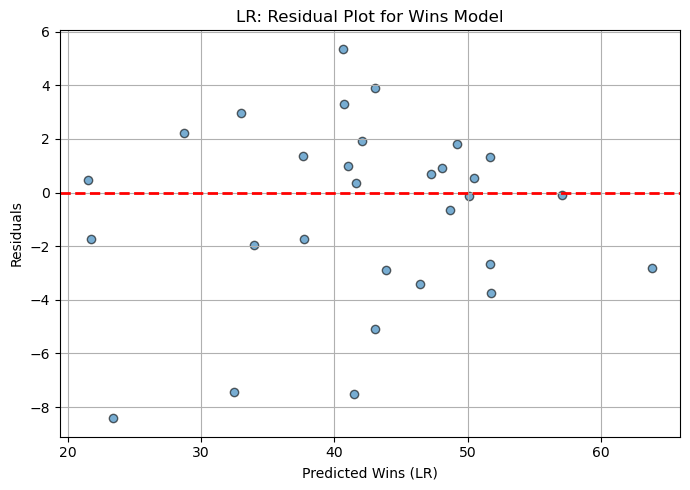


  --- Random Forest ---
    RF R-squared: 0.868
    RF MAE: 3.175
    RF RMSE: 15.229


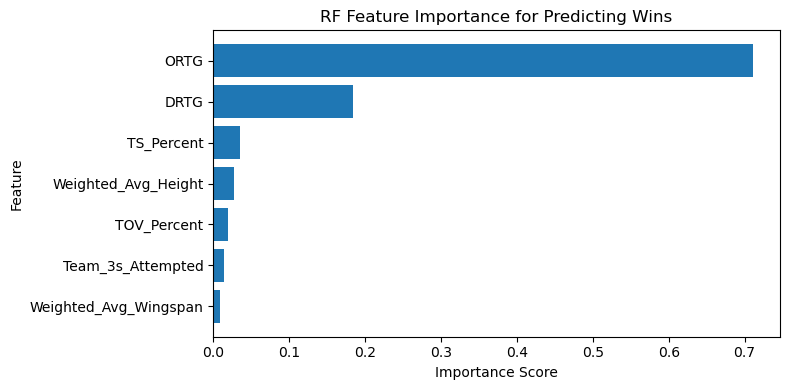


  --- SHAP Analysis (using Random Forest model) ---


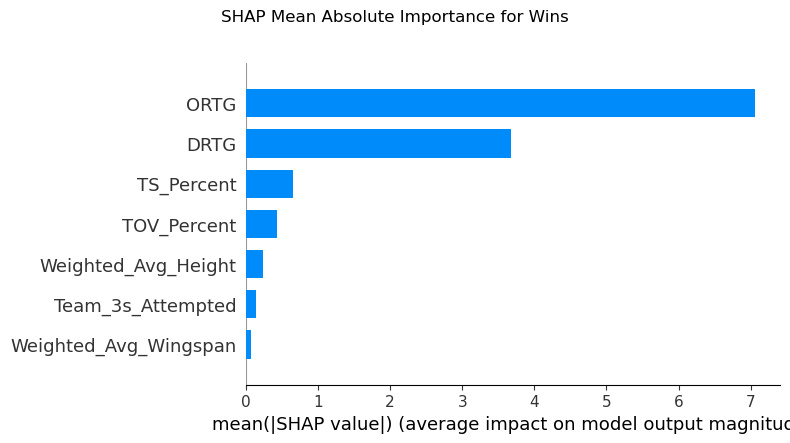

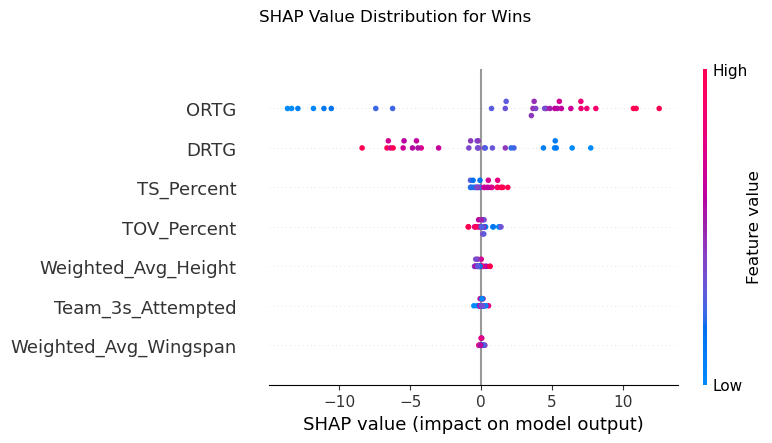


--- Analyzing Target: ORTG ---
  Features used: ['DRTG', 'TS_Percent', 'TOV_Percent', 'Team_3s_Attempted', 'Weighted_Avg_Height', 'Weighted_Avg_Wingspan']

  --- Linear Regression ---
    LR R-squared: 0.649
    LR MAE: 1.375
    LR RMSE: 2.904


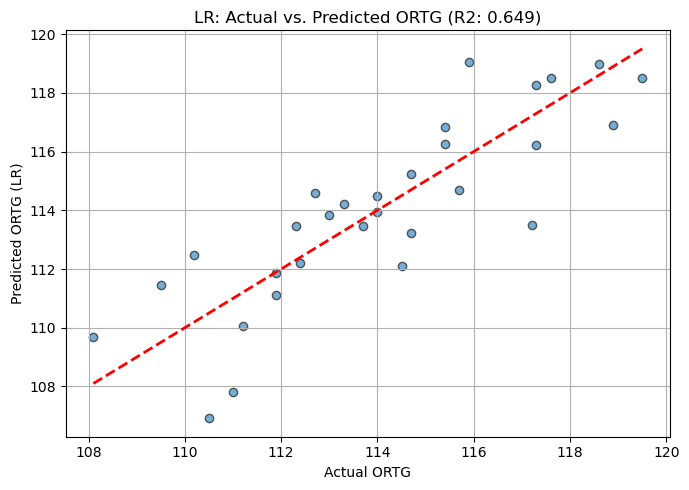

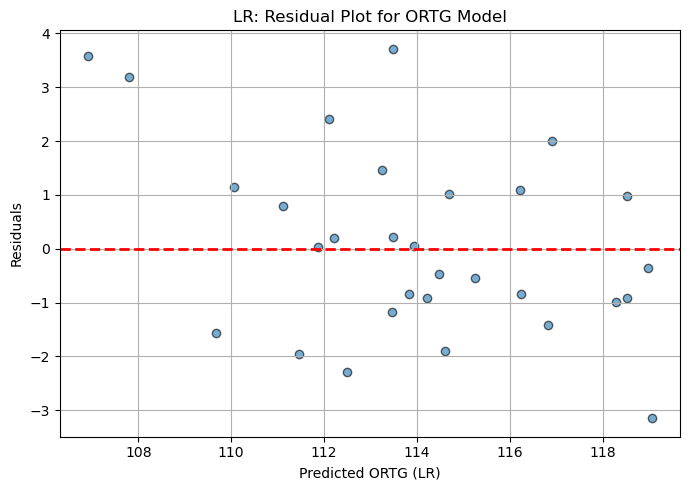


  --- Random Forest ---
    RF R-squared: 0.697
    RF MAE: 1.380
    RF RMSE: 2.507


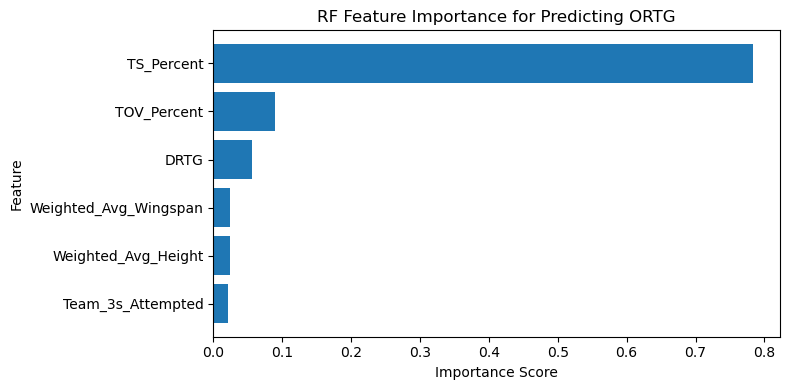


  --- SHAP Analysis (using Random Forest model) ---


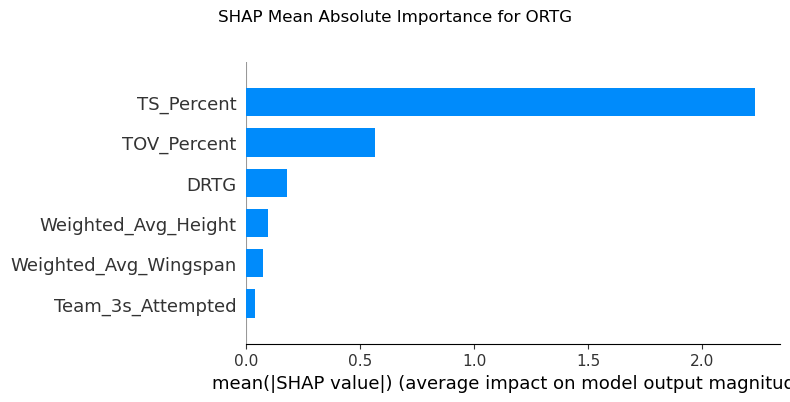

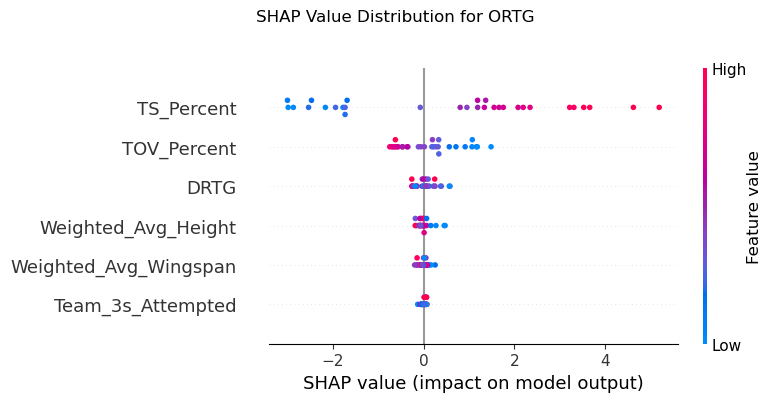


--- Analysis Loop Complete ---

--- Model Performance Comparison ---
               R2       MAE       RMSE
Wins_LR  0.899002  2.612654  11.659196
Wins_RF  0.868075  3.175333  15.229460
ORTG_LR  0.648643  1.374576   2.904411
ORTG_RF  0.696695  1.380300   2.507199


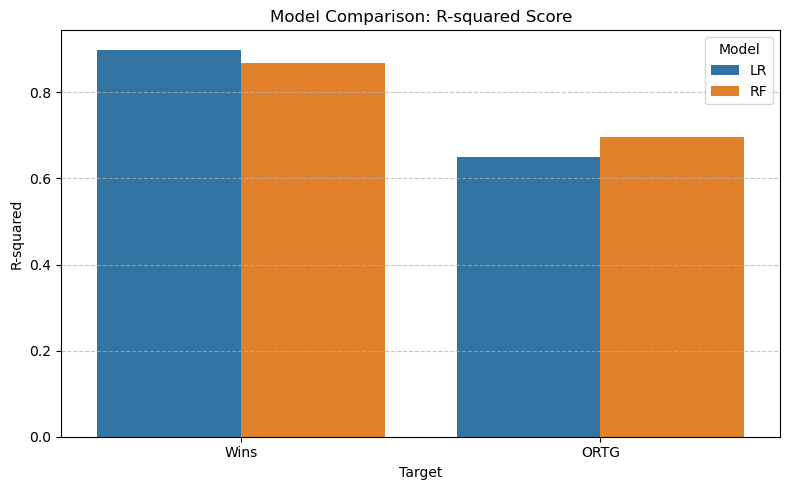


--- Summary Guidance ---
Review the generated plots and tables above.
Key items for your report/presentation:
1. Model Performance Table & Plot: Compare Linear Regression vs. Random Forest.
2. RF Feature Importance Plots: Show rankings for predicting Wins and ORTG.
3. SHAP Plots (Bar & Beeswarm): Explain *how* top features impact Wins and ORTG (direction & magnitude).
4. Actual vs. Predicted & Residual Plots (LR): Briefly show model fit and diagnostics for the simpler model.

Next Steps:
- Synthesize findings: List the top drivers for Wins & ORTG based on RF/SHAP.
- Refer back to the 'statsmodels' output (run separately) for p-values and statistical significance of linear relationships.
- Incorporate these visuals and numbers into your report and presentation slides, ensuring you compare methods and discuss results clearly.


In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor # Added
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap # Added

# --- 1. Load and Prepare Data ---
# (Assuming this part is correct and combined_df is created and cleaned)
load_path = '../data/cleandata/' # Adjust if needed
start_year = 2021
end_year = 2024 # Adjust if needed
seasons = [f"{str(year)[-2:]}-{str(year+1)[-2:]}" for year in range(start_year, end_year + 1)] 

all_data = []
print(f"Loading data for seasons: {seasons} to create combined_df")

# --- (Keep the data loading and cleaning loop as before) ---
for season in seasons:
    file_path = os.path.join(load_path, f'{season}.csv')
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
        except Exception as e:
            print(f"  Error loading {file_path}: {e}")
    else:
        print(f"  Warning: File not found {file_path}")

if not all_data:
    print("Error: No data loaded. Exiting.")
    exit()
else:
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Combined data shape: {combined_df.shape}")
    
    # Optional: Repeat basic NaN handling
    numeric_cols_to_check = combined_df.select_dtypes(include=np.number).columns
    for col in numeric_cols_to_check:
        if combined_df[col].isnull().any():
            median_val = combined_df[col].median()
            combined_df[col].fillna(median_val, inplace=True)
            # print(f"  Filled NaNs in '{col}' with median ({median_val:.2f})") 

# --- 2. Define Feature Sets and Targets ---
base_features = [
    'ORTG', 
    'DRTG', 
    'TS_Percent', 
    'TOV_Percent', 
    'Team_3s_Attempted', 
    'Weighted_Avg_Height', 
    'Weighted_Avg_Wingspan'
]
targets = ['Wins', 'ORTG']

# --- 3. Initialize Results Storage ---
model_results = {} # To store metrics for comparison

# --- 4. Loop Through Targets for Analysis ---
for target in targets:
    print(f"\n--- Analyzing Target: {target} ---")
    
    # --- (Keep Feature Selection Logic as before) ---
    if target == 'Wins':
        current_features = [f for f in base_features if f in combined_df.columns]
    elif target == 'ORTG':
        current_features = [f for f in base_features if f != 'ORTG' and f in combined_df.columns]
    else:
        print(f"Target {target} not configured. Skipping.")
        continue    
    if not current_features:
        print(f"  No valid features found for target {target}. Skipping.")
        continue   
    X = combined_df[current_features]
    y = combined_df[target]
    if X.empty or y.empty:
        print(f"  Feature set or target is empty for {target}. Skipping.")
        continue

    # --- (Keep Split and Scale Data as before) ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"  Features used: {current_features}")

    # --- 5. Linear Regression (Keep as before) ---
    print("\n  --- Linear Regression ---")
    model_lr = LinearRegression()
    model_lr.fit(X_train_scaled, y_train)
    y_pred_lr = model_lr.predict(X_test_scaled)
    r2_lr = r2_score(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    rmse_lr = mean_squared_error(y_test, y_pred_lr)
    print(f"    LR R-squared: {r2_lr:.3f}")
    print(f"    LR MAE: {mae_lr:.3f}")
    print(f"    LR RMSE: {rmse_lr:.3f}")
    # Store results
    model_results[f'{target}_LR'] = {'R2': r2_lr, 'MAE': mae_lr, 'RMSE': rmse_lr}
    # Keep Actual vs Predicted Plot for LR
    plt.figure(figsize=(7, 5))
    plt.scatter(y_test, y_pred_lr, alpha=0.6, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target} (LR)")
    plt.title(f"LR: Actual vs. Predicted {target} (R2: {r2_lr:.3f})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Keep Residual Plot for LR
    residuals_lr = y_test - y_pred_lr
    plt.figure(figsize=(7, 5))
    plt.scatter(y_pred_lr, residuals_lr, alpha=0.6, edgecolors='k')
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel(f"Predicted {target} (LR)")
    plt.ylabel("Residuals")
    plt.title(f"LR: Residual Plot for {target} Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 6. Random Forest Regression (Added) ---
    print("\n  --- Random Forest ---")
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    # RF can work on scaled or unscaled data. Let's use scaled for consistency here.
    model_rf.fit(X_train_scaled, y_train)
    y_pred_rf = model_rf.predict(X_test_scaled)
    r2_rf = r2_score(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = mean_squared_error(y_test, y_pred_rf)
    print(f"    RF R-squared: {r2_rf:.3f}")
    print(f"    RF MAE: {mae_rf:.3f}")
    print(f"    RF RMSE: {rmse_rf:.3f}")
    # Store results
    model_results[f'{target}_RF'] = {'R2': r2_rf, 'MAE': mae_rf, 'RMSE': rmse_rf}
    # RF Feature Importance Plot
    importances_rf = model_rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': current_features, 'Importance': importances_rf})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(8, max(4, len(current_features)*0.4))) # Adjust height dynamically
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"RF Feature Importance for Predicting {target}")
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

    # --- 7. SHAP Analysis (Added) ---
    print("\n  --- SHAP Analysis (using Random Forest model) ---")
    # Using X_test_scaled because RF was trained on scaled data
    # For SHAP interpretation, it's often useful to pass the original X_test 
    # dataframe for feature names and context, but calculate on scaled values
    X_test_df = pd.DataFrame(X_test_scaled, columns=current_features) # Create df for shap plot labels
    
    explainer = shap.TreeExplainer(model_rf)
    shap_values = explainer.shap_values(X_test_scaled) 

    # SHAP Bar Plot (Global Importance)
    plt.figure()
    shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
    # Manually add title as SHAP sometimes overwrites plt.title
    fig = plt.gcf()
    fig.suptitle(f"SHAP Mean Absolute Importance for {target}", y=1.02) # Adjust y if needed
    plt.tight_layout()
    plt.show()
    
    # SHAP Beeswarm Plot
    plt.figure()
    shap.summary_plot(shap_values, X_test_df, show=False)
    fig = plt.gcf()
    fig.suptitle(f"SHAP Value Distribution for {target}", y=1.02) # Adjust y if needed
    plt.tight_layout()
    plt.show()

print("\n--- Analysis Loop Complete ---")

# --- 8. Post-Loop Summaries & Comparisons ---

# Create Performance Comparison Table
results_df = pd.DataFrame(model_results).T # Transpose for better table layout
print("\n--- Model Performance Comparison ---")
print(results_df)

# Create Performance Comparison Plot (R-squared)
r2_data = results_df['R2']
if isinstance(results_df.index, pd.MultiIndex): # Handle potential MultiIndex if stored differently
     r2_data = results_df['R2'].unstack(level=1)
else: # Assuming index is like 'Wins_LR', 'Wins_RF', 'ORTG_LR', 'ORTG_RF'
     r2_data_dict = {'Target': [], 'Model': [], 'R2': []}
     for idx, row in results_df.iterrows():
         target_name, model_name = idx.split('_')
         r2_data_dict['Target'].append(target_name)
         r2_data_dict['Model'].append(model_name)
         r2_data_dict['R2'].append(row['R2'])
     r2_data_plot = pd.DataFrame(r2_data_dict)

plt.figure(figsize=(8, 5))
sns.barplot(data=r2_data_plot, x='Target', y='R2', hue='Model')
plt.title('Model Comparison: R-squared Score')
plt.ylabel('R-squared')
plt.ylim(bottom=min(0, r2_data_plot['R2'].min() - 0.05)) # Adjust y-axis start
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 9. Summary Guidance (Text Output) ---
print("\n--- Summary Guidance ---")
print("Review the generated plots and tables above.")
print("Key items for your report/presentation:")
print("1. Model Performance Table & Plot: Compare Linear Regression vs. Random Forest.")
print("2. RF Feature Importance Plots: Show rankings for predicting Wins and ORTG.")
print("3. SHAP Plots (Bar & Beeswarm): Explain *how* top features impact Wins and ORTG (direction & magnitude).")
print("4. Actual vs. Predicted & Residual Plots (LR): Briefly show model fit and diagnostics for the simpler model.")
print("\nNext Steps:")
print("- Synthesize findings: List the top drivers for Wins & ORTG based on RF/SHAP.")
print("- Refer back to the 'statsmodels' output (run separately) for p-values and statistical significance of linear relationships.")
print("- Incorporate these visuals and numbers into your report and presentation slides, ensuring you compare methods and discuss results clearly.")